In [1]:
!pip3 install transformers
!pip3 install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.8 MB/s 
     |████████████████████████████████| 7.6 MB 42.9 MB/s 
     |████████████████████████████████| 163 kB 50.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.4 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=06cf571402b7a4550e74d88753509c5b924fc911e777ed9b778a56f51fe8d405
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [2]:
import torch
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer 
import tensorflow as tf
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import locale

import os
import time

In [3]:
# Clone github repo containing the data as csv file
! rm -rf covid_data
! git clone https://github.com/PatrickNiccolai2/covid_data

Cloning into 'covid_data'...
remote: Enumerating objects: 2036, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 2036 (delta 23), reused 85 (delta 20), pack-reused 1948
Receiving objects: 100% (2036/2036), 270.54 MiB | 25.13 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [4]:
# Download the tweets with sentiment data
!unzip /content/covid_data/tweets_with_sent -d /content/covid_data/unzip_tweets_with_sent

Streaming output truncated to the last 5000 lines.
  inflating: /content/covid_data/unzip_tweets_with_sent/tweets_with_sent/sent_shuffled_tweet_118805.txt  
  inflating: /content/covid_data/unzip_tweets_with_sent/tweets_with_sent/sent_shuffled_tweet_65049.txt  
  inflating: /content/covid_data/unzip_tweets_with_sent/tweets_with_sent/sent_shuffled_tweet_43930.txt  
  inflating: /content/covid_data/unzip_tweets_with_sent/tweets_with_sent/sent_shuffled_tweet_112496.txt  
  inflating: /content/covid_data/unzip_tweets_with_sent/tweets_with_sent/sent_shuffled_tweet_123893.txt  
  inflating: /content/covid_data/unzip_tweets_with_sent/tweets_with_sent/sent_shuffled_tweet_72535.txt  
  inflating: /content/covid_data/unzip_tweets_with_sent/tweets_with_sent/sent_shuffled_tweet_6089.txt  
  inflating: /content/covid_data/unzip_tweets_with_sent/tweets_with_sent/sent_shuffled_tweet_34560.txt  
  inflating: /content/covid_data/unzip_tweets_with_sent/tweets_with_sent/sent_shuffled_tweet_45399.txt  
  

In [5]:
# Read all of the tweets + other data into an array
all_files_text = []

# Iterate through folder we just unzipped
for filename in os.listdir("/content/covid_data/unzip_tweets_with_sent/tweets_with_sent"):
  if(filename[0] == "s"):
    # Open each file and read it
    file_path = "/content/covid_data/unzip_tweets_with_sent/tweets_with_sent/" + filename
    file = open(file_path, "r")
    lines = file.read()

    # Split the file into different parts
    lines_arr = lines.split("\n\n")
    sent = lines_arr[-1]
    id = lines_arr[-2]
    place = lines_arr[-3]
    coords = lines_arr[-4]
    time = lines_arr[-5]

    tweet_text = ""
    for i in range(5, len(lines_arr) + 1):
      tweet_text = tweet_text + lines_arr[-i]

    # Search the tweet text for a manufacturer, if one is mentioned
    if("johnson" not in tweet_text.lower()):
      man = "no_man"
      if("sputnik" in tweet_text.lower()):
        man = "sputnik"
      if("sinopharm" in tweet_text.lower() or "sinovac" in tweet_text.lower()):
        man = "sino"
      if("moderna" in tweet_text.lower() or "spikevax" in tweet_text.lower()):
        man = "moderna"
      if("pfizer" in tweet_text.lower() or "biontech" in tweet_text.lower() or "comirnaty" in tweet_text.lower()):
        man = "pfizer"
      if("janssen" in tweet_text.lower()):
        man = "janssen"
      if("astrazeneca" in tweet_text.lower() or "vaxzevria" in tweet_text.lower()):
        man = "astra"
        
      # Add all the info from the file to all_files_text
      full_tweet = [tweet_text, time, coords, place, id, man, sent]
      all_files_text.append(full_tweet)
    file.close()


In [6]:
# This is how many tweets we have
print(len(all_files_text))

114549


In [7]:
# Create a dataframe with all of the data
all_tweets_df = pd.DataFrame(all_files_text, columns=["tweet_text", "time", "coords", "place", "tweet_id", "man", "sentiment"])

In [8]:
print(all_tweets_df.head(10))

                                          tweet_text  \
0  2021-04-29 13:09:32+00:00@HellOnHeels2020 It w...   
1  2021-03-25 01:13:10+00:00When NYers needed vac...   
2  2021-07-02 18:42:54+00:00Checkout @watvaxtrack...   
3  2021-06-02 08:41:02+00:00Completely agree with...   
4  2021-03-16 11:00:30+00:00@MajorDMalpas Delays ...   
5  2021-04-07 21:00:50+00:00For #WorldHealthDay i...   
6  2021-03-06 05:24:03+00:00So... #toronto has be...   
7  2021-08-28 17:44:57+00:00https://t.co/iyNARb3Y...   
8  2021-06-13 23:47:01+00:00@chhardman Well if yo...   
9  2021-04-01 06:47:59+00:00ZERO long term trials...   

                        time coords  \
0  2021-04-29 13:09:32+00:00   None   
1  2021-03-25 01:13:10+00:00   None   
2  2021-07-02 18:42:54+00:00   None   
3  2021-06-02 08:41:02+00:00   None   
4  2021-03-16 11:00:30+00:00   None   
5  2021-04-07 21:00:50+00:00   None   
6  2021-03-06 05:24:03+00:00   None   
7  2021-08-28 17:44:57+00:00   None   
8  2021-06-13 23:47:01+00:00   N

In [9]:
# Convert strings to datetime so they can be used
def str_to_datetime(in_str):
  date = in_str.split(" ")[0]
  out_datetime = datetime.strptime(date,"%Y-%m-%d")
  return out_datetime

all_tweets_df["datetime"] = all_tweets_df["time"].apply(str_to_datetime)

In [10]:
# The sentiment is an array containing 3 values, convert it to one value
def sent_arr_to_val(sent_str):
  sent_str = sent_str[2:-2]
  sent_arr = sent_str.split()
    # We define the sentiment value as probability of positive sentiment minus probability of negative sentiment
  return float(sent_arr[2]) - float(sent_arr[0])

all_tweets_df["sent_avg"] = all_tweets_df["sentiment"].apply(sent_arr_to_val)

In [11]:
print(all_tweets_df.head(10))

                                          tweet_text  \
0  2021-04-29 13:09:32+00:00@HellOnHeels2020 It w...   
1  2021-03-25 01:13:10+00:00When NYers needed vac...   
2  2021-07-02 18:42:54+00:00Checkout @watvaxtrack...   
3  2021-06-02 08:41:02+00:00Completely agree with...   
4  2021-03-16 11:00:30+00:00@MajorDMalpas Delays ...   
5  2021-04-07 21:00:50+00:00For #WorldHealthDay i...   
6  2021-03-06 05:24:03+00:00So... #toronto has be...   
7  2021-08-28 17:44:57+00:00https://t.co/iyNARb3Y...   
8  2021-06-13 23:47:01+00:00@chhardman Well if yo...   
9  2021-04-01 06:47:59+00:00ZERO long term trials...   

                        time coords  \
0  2021-04-29 13:09:32+00:00   None   
1  2021-03-25 01:13:10+00:00   None   
2  2021-07-02 18:42:54+00:00   None   
3  2021-06-02 08:41:02+00:00   None   
4  2021-03-16 11:00:30+00:00   None   
5  2021-04-07 21:00:50+00:00   None   
6  2021-03-06 05:24:03+00:00   None   
7  2021-08-28 17:44:57+00:00   None   
8  2021-06-13 23:47:01+00:00   N

In [12]:
# This cells creates a new dataframe with a row for each day, containing the average
# sentiment value and the variacnce of sentiment values for that day

aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

all_tweets_df["sent_var"] = all_tweets_df["sent_avg"]

samples_per_day_df = all_tweets_df.groupby(["datetime"]).agg(aggregator)
samples_per_day_df = samples_per_day_df.sort_index()
samples_per_day_df.reset_index(inplace=True)
samples_per_day_df = samples_per_day_df.rename(columns = {'index':'datetime'})
print(samples_per_day_df.head(-10))

      datetime  tweet_text  time  coords  tweet_id  sentiment  sent_avg  \
0   2019-11-19          11    11      11        11         11 -0.158187   
1   2019-11-20          12    12      12        12         12 -0.187530   
2   2019-11-21           5     5       5         5          5 -0.319780   
3   2019-11-22           8     8       8         8          8  0.052413   
4   2019-11-23           9     9       9         9          9 -0.432920   
..         ...         ...   ...     ...       ...        ...       ...   
646 2021-08-26         389   389     389       389        389 -0.319344   
647 2021-08-27         347   347     347       347        347 -0.326155   
648 2021-08-28         287   287     287       287        287 -0.317638   
649 2021-08-29         285   285     285       285        285 -0.383587   
650 2021-08-30         282   282     282       282        282 -0.358187   

     sent_var  
0    0.561319  
1    0.396492  
2    0.238500  
3    0.194041  
4    0.157587  
.. 

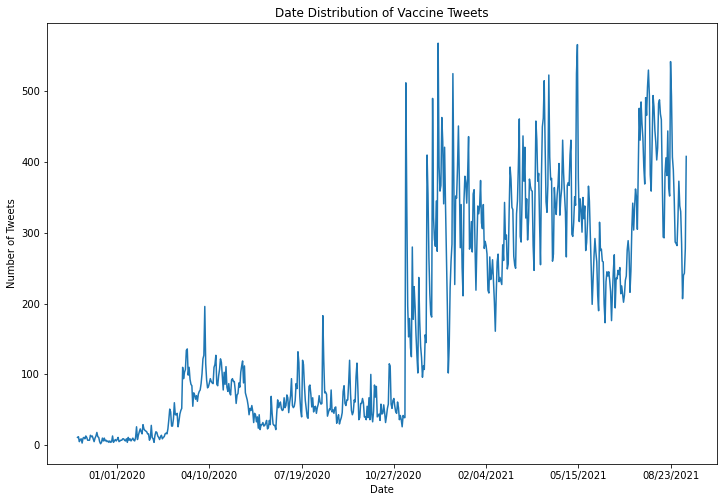

In [13]:
# Plot date distribution of tweets we collected
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(samples_per_day_df["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Date Distribution of Vaccine Tweets")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(samples_per_day_df["datetime"],samples_per_day_df["tweet_text"])
plt.show()

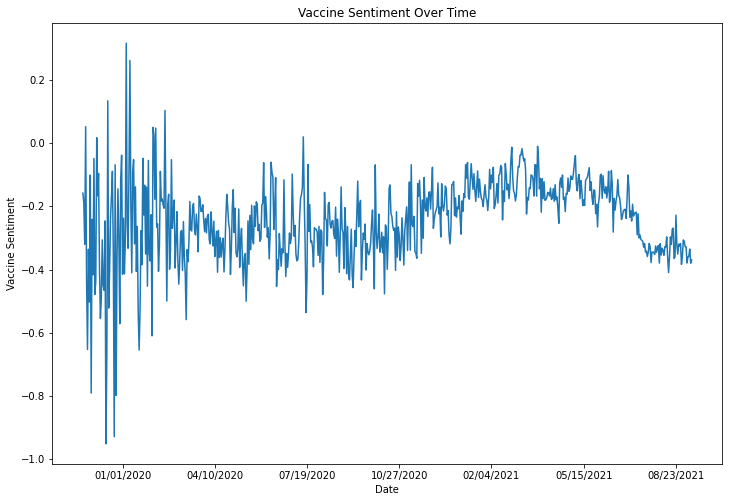

In [14]:
# Plot average vaccine sentiment per day
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(samples_per_day_df["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Vaccine Sentiment Over Time")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(samples_per_day_df["datetime"],samples_per_day_df["sent_avg"])
plt.show()

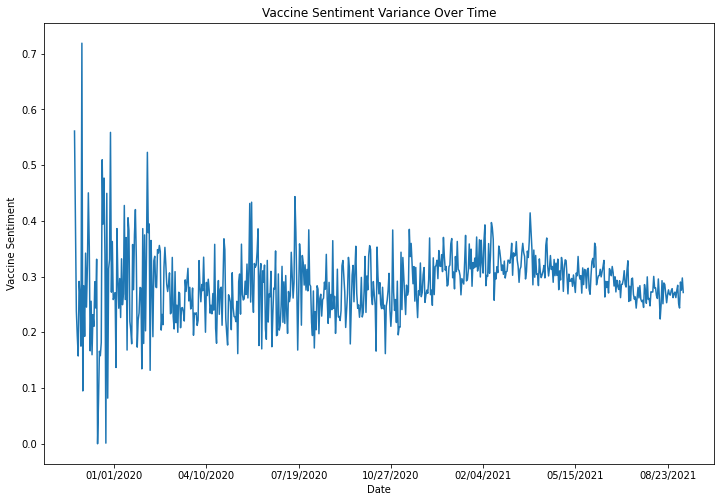

In [15]:
# Plot variance in vaccine sentiment per day
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(samples_per_day_df["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Vaccine Sentiment Variance Over Time")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(samples_per_day_df["datetime"],samples_per_day_df["sent_var"])
plt.show()

In [16]:
# This cell counts how many tweets mention a manufacturer

num_sputnik = 0
num_sino = 0
num_moderna = 0
num_pfizer = 0
num_janssen = 0
num_astra = 0

sputnik_arr = []
sino_arr = []
moderna_arr = []
pfizer_arr = []
janssen_arr = []
astra_arr = []
for file in all_files_text:
  tweet_text = file[0]
  if("sputnik" in tweet_text.lower()):
    num_sputnik += 1
    sputnik_arr.append(file)
  if("sinopharm" in tweet_text.lower() or "sinovac" in tweet_text.lower()):
    num_sino += 1
    sino_arr.append(file)
  if("moderna" in tweet_text.lower() or "spikevax" in tweet_text.lower()):
    num_moderna += 1
    moderna_arr.append(file)
  if("pfizer" in tweet_text.lower() or "biontech" in tweet_text.lower() or "comirnaty" in tweet_text.lower()):
    num_pfizer += 1
    pfizer_arr.append(file)
  if("janssen" in tweet_text.lower() or "johnson" in tweet_text.lower()):
    num_janssen += 1
    janssen_arr.append(file)
  if("astrazeneca" in tweet_text.lower() or "vaxzevria" in tweet_text.lower()):
    num_astra += 1
    astra_arr.append(file)

print("sputnik: " + str(num_sputnik))
print("sino: " + str(num_sino))
print("moderna: " + str(num_moderna))
print("pfizer: " + str(num_pfizer))
print("janssen: " + str(num_janssen))
print("astrazeneca: " + str(num_astra))

sputnik: 701
sino: 676
moderna: 1975
pfizer: 5140
janssen: 107
astrazeneca: 1832


In [17]:
# Create a dataframe of only moderna tweets
moderna_df = all_tweets_df[all_tweets_df["man"] == "moderna"]

In [18]:
# Create a dataframe of only moderna tweets grouped by day
aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

moderna_per_day = moderna_df.groupby(["datetime"]).agg(aggregator)
moderna_per_day = moderna_per_day.sort_index()
moderna_per_day.reset_index(inplace=True)
moderna_per_day = moderna_per_day.rename(columns = {'index':'datetime'})

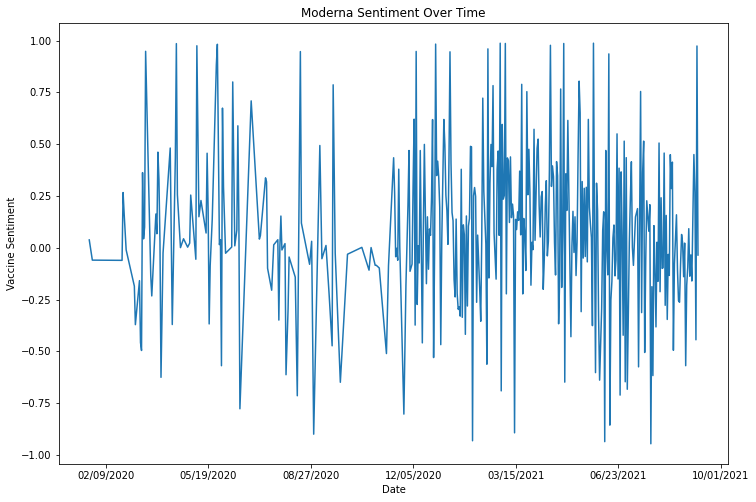

In [19]:
# Plot sentiment by day for moderna
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(moderna_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Moderna Sentiment Over Time")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(moderna_per_day["datetime"],moderna_per_day["sent_avg"])
plt.show()

In [20]:
# Do same thing for pfizer
pfizer_df = all_tweets_df[all_tweets_df["man"] == "pfizer"]

aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

pfizer_per_day = pfizer_df.groupby(["datetime"]).agg(aggregator)
pfizer_per_day = pfizer_per_day.sort_index()
pfizer_per_day.reset_index(inplace=True)
pfizer_per_day = pfizer_per_day.rename(columns = {'index':'datetime'})

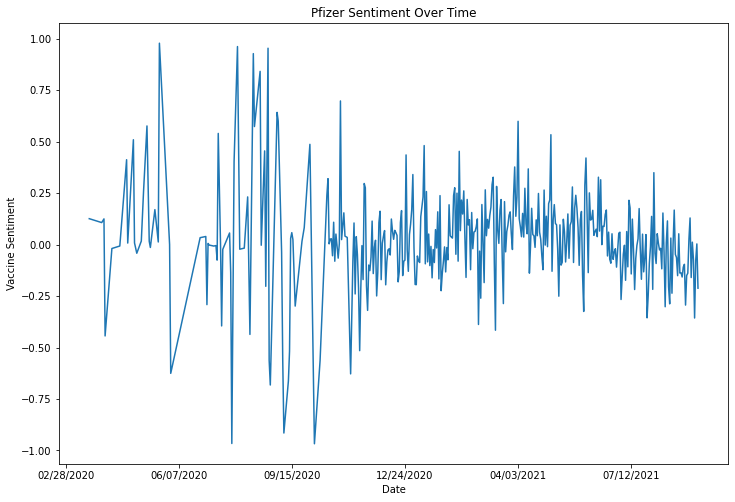

In [21]:
# Plot sentiment per day for pfizer
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(pfizer_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Pfizer Sentiment Over Time")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(pfizer_per_day["datetime"],pfizer_per_day["sent_avg"])
plt.show()

In [22]:
# Do same thing for astrazenca
astra_df = all_tweets_df[all_tweets_df["man"] == "astra"]

aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

astra_per_day = astra_df.groupby(["datetime"]).agg(aggregator)
astra_per_day = astra_per_day.sort_index()
astra_per_day.reset_index(inplace=True)
astra_per_day = astra_per_day.rename(columns = {'index':'datetime'})

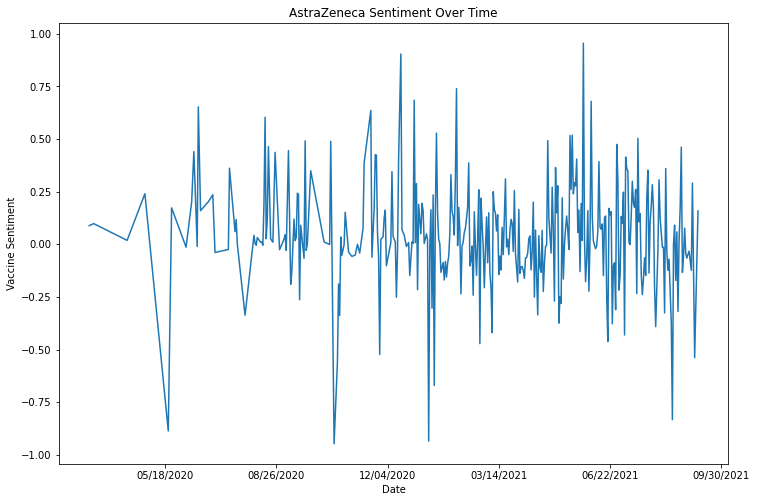

In [23]:
# Plot sentiment per day for astrazeneca
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(astra_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("AstraZeneca Sentiment Over Time")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(astra_per_day["datetime"],astra_per_day["sent_avg"])
plt.show()

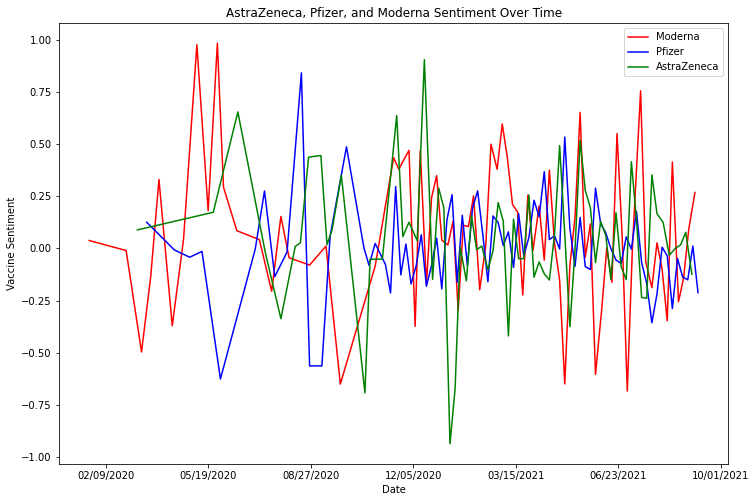

In [24]:
# all the sentiments on one plot over time for the baseline 

# how to make this only plot from Dec 2020 to March 2021?
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(astra_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("AstraZeneca, Pfizer, and Moderna Sentiment Over Time")

ax.plot(moderna_per_day["datetime"][::5],moderna_per_day["sent_avg"][::5],'red', label='Moderna')
ax.plot(pfizer_per_day["datetime"][::5],pfizer_per_day["sent_avg"][::5],'blue', label='Pfizer')
ax.plot(astra_per_day["datetime"][::5],astra_per_day["sent_avg"][::5],'green', label='AstraZeneca')
leg = ax.legend()

In [25]:
# compare to baseline
# calculate mean score for moderna 
  # December 2020 - 0.368±0.450
  # January 2021 -  0.119±0.532
  # febuary 2021 -  0.312±0.144
  # march 2021 - 0.397±0.166

# calculate mean score for pfizer 
  # December 2020 - 0.218±0.308
  # January 2021 - 0.116±0.238
  # febuary 2021 -  0.265±0.207
  # march 2021 - 0.212±0.187

# calculate mean score for AZ and compare to values
  # December 2020 -  0.693±0.265
  # January 2021 - 0.316±0.261
  # febuary 2021 -  0.241±0.204
  # march 2021 - −0.0528±0.238




In [26]:
# sinopharm
sinopharm_df = all_tweets_df[all_tweets_df["man"] == "sino"]

aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

sinopharm_per_day = sinopharm_df.groupby(["datetime"]).agg(aggregator)
sinopharm_per_day = sinopharm_per_day.sort_index()
sinopharm_per_day.reset_index(inplace=True)
sinopharm_per_day = sinopharm_per_day.rename(columns = {'index':'datetime'})




# sputnik
sputnik_df = all_tweets_df[all_tweets_df["man"] == "sputnik"]

aggregator = {'tweet_text' : 'count', 'time' : 'count', 'coords': 'count', 
              'tweet_id' : 'count', 'sentiment': 'count', 'sent_avg': 'mean',
              'sent_var' : 'var'}

sputnik_per_day = sputnik_df.groupby(["datetime"]).agg(aggregator)
sputnik_per_day = sputnik_per_day.sort_index()
sputnik_per_day.reset_index(inplace=True)
sputnik_per_day = sputnik_per_day.rename(columns = {'index':'datetime'})


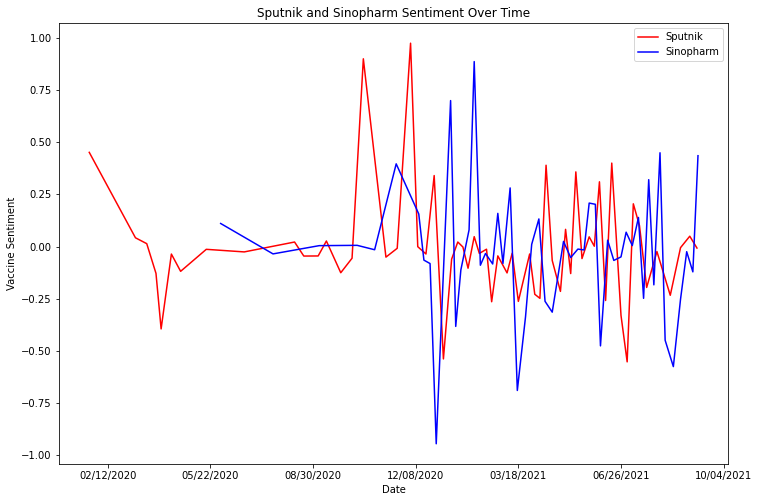

In [27]:
# all the sentiments on one plot over time for the baseline
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.xticks(sputnik_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Sputnik and Sinopharm Sentiment Over Time")

ax.plot(sputnik_per_day["datetime"][::5],sputnik_per_day["sent_avg"][::5],'red', label='Sputnik')
ax.plot(sinopharm_per_day["datetime"][::5],sinopharm_per_day["sent_avg"][::5],'blue', label='Sinopharm')
leg = ax.legend()

# issue: how do we get this to extend to 2022 data as well??

        month  sent_avg
0  2020-06-01  0.056101
1  2020-07-01 -0.009347
2  2020-08-01  0.217159
3  2020-09-01  0.093861
4  2020-10-01  0.039804
5  2020-11-01  0.069851
6  2020-12-01 -0.062139
7  2021-01-01 -0.051280
8  2021-02-01  0.047934
9  2021-03-01  0.057342
10 2021-04-01 -0.190001
11 2021-05-01  0.004466
12 2021-06-01  0.040598
13 2021-07-01  0.062245
14 2021-08-01  0.023939
15 2021-09-01  0.023351


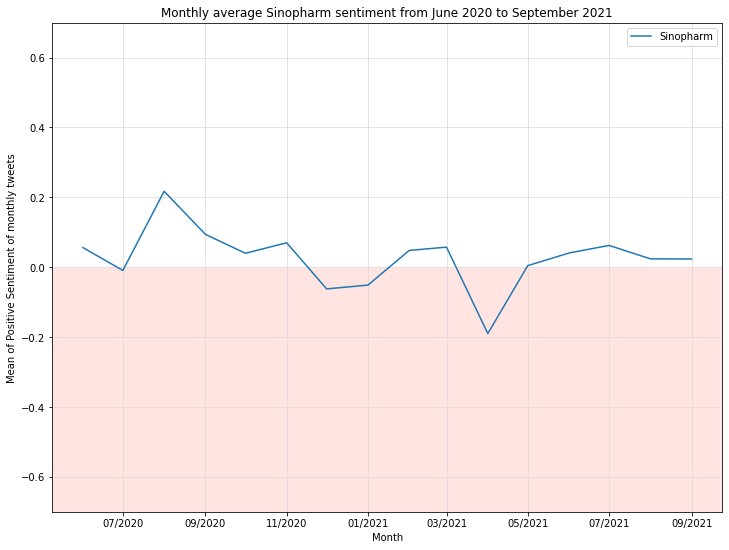

In [28]:
# graphing mean of sentiment for each month of sinopharm
sinopharm_month = sinopharm_per_day.copy()

def startMonth(date):
  month = date.month
  year = date.year
  comp_date = str(year) + "-" + str(month) + "-1"
  return datetime.strptime(comp_date, "%Y-%m-%d")

sinopharm_month["month"] = sinopharm_month["datetime"].apply(startMonth)

sinopharm_avg_month = sinopharm_month.groupby("month")["sent_avg"].mean().reset_index()

print(sinopharm_avg_month)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Sinopharm sentiment from June 2020 to September 2021")
plt.plot(sinopharm_avg_month["month"],sinopharm_avg_month["sent_avg"], label='Sinopharm')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()


        month  sent_avg
0  2020-01-01  0.451401
1  2020-02-01 -0.057906
2  2020-03-01 -0.069203
3  2020-04-01 -0.199375
4  2020-05-01  0.068150
5  2020-06-01 -0.058099
6  2020-07-01 -0.152829
7  2020-08-01 -0.080481
8  2020-09-01  0.039858
9  2020-10-01 -0.115118
10 2020-11-01 -0.068469
11 2020-12-01 -0.045195
12 2021-01-01 -0.102311
13 2021-02-01  0.001502
14 2021-03-01 -0.105742
15 2021-04-01 -0.089164
16 2021-05-01 -0.011503
17 2021-06-01  0.004052
18 2021-07-01  0.039972
19 2021-08-01 -0.098442
20 2021-09-01  0.056801


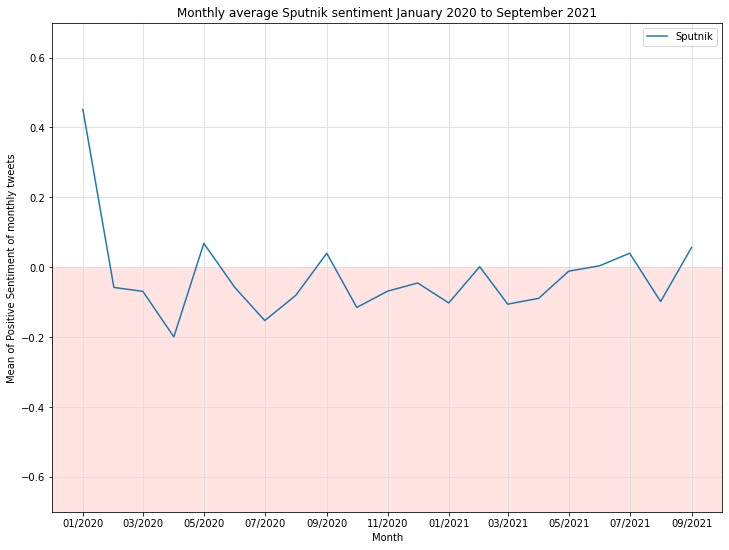

In [29]:
# graphing mean of sentiment for each month of sputnik
sputnik_month = sputnik_per_day.copy()

def startMonth(date):
  month = date.month
  year = date.year
  comp_date = str(year) + "-" + str(month) + "-1"
  return datetime.strptime(comp_date, "%Y-%m-%d")

sputnik_month["month"] = sputnik_month["datetime"].apply(startMonth)

sputnik_avg_month = sputnik_month.groupby("month")["sent_avg"].mean().reset_index()

print(sputnik_avg_month)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Sputnik sentiment January 2020 to September 2021")
plt.plot(sputnik_avg_month["month"],sputnik_avg_month["sent_avg"], label='Sputnik')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

        month  sent_avg
0  2020-01-01 -0.011011
1  2020-02-01  0.091041
2  2020-03-01  0.007934
3  2020-04-01  0.128492
4  2020-05-01  0.242864
5  2020-06-01  0.159801
6  2020-07-01  0.025216
7  2020-08-01 -0.152288
8  2020-09-01 -0.016396
9  2020-10-01 -0.050982
10 2020-11-01 -0.038550
11 2020-12-01  0.167054
12 2021-01-01  0.090597
13 2021-02-01  0.168528
14 2021-03-01  0.174473
15 2021-04-01  0.200460
16 2021-05-01  0.176993
17 2021-06-01 -0.073947
18 2021-07-01 -0.037973
19 2021-08-01 -0.025172
20 2021-09-01  0.109986


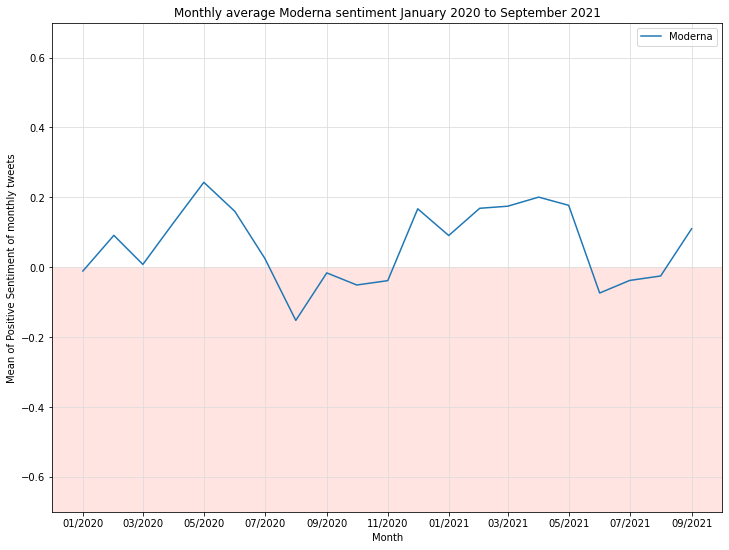

In [30]:
# graphing mean of sentiment for each month of moderna
moderna_month = moderna_per_day.copy()

def startMonth(date):
  month = date.month
  year = date.year
  comp_date = str(year) + "-" + str(month) + "-1"
  return datetime.strptime(comp_date, "%Y-%m-%d")

moderna_month["month"] = moderna_month["datetime"].apply(startMonth)

moderna_avg_month = moderna_month.groupby("month")["sent_avg"].mean().reset_index()

print(moderna_avg_month)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Moderna sentiment January 2020 to September 2021")
plt.plot(moderna_avg_month["month"],moderna_avg_month["sent_avg"], label='Moderna')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

        month  sent_avg
0  2020-03-01  0.115972
1  2020-04-01  0.073646
2  2020-05-01  0.122339
3  2020-06-01  0.033244
4  2020-07-01  0.019898
5  2020-08-01  0.172814
6  2020-09-01 -0.118786
7  2020-10-01  0.023921
8  2020-11-01 -0.097433
9  2020-12-01  0.026006
10 2021-01-01 -0.008019
11 2021-02-01  0.082757
12 2021-03-01  0.076160
13 2021-04-01  0.107011
14 2021-05-01  0.056038
15 2021-06-01  0.080866
16 2021-07-01 -0.044919
17 2021-08-01 -0.061628
18 2021-09-01 -0.078980


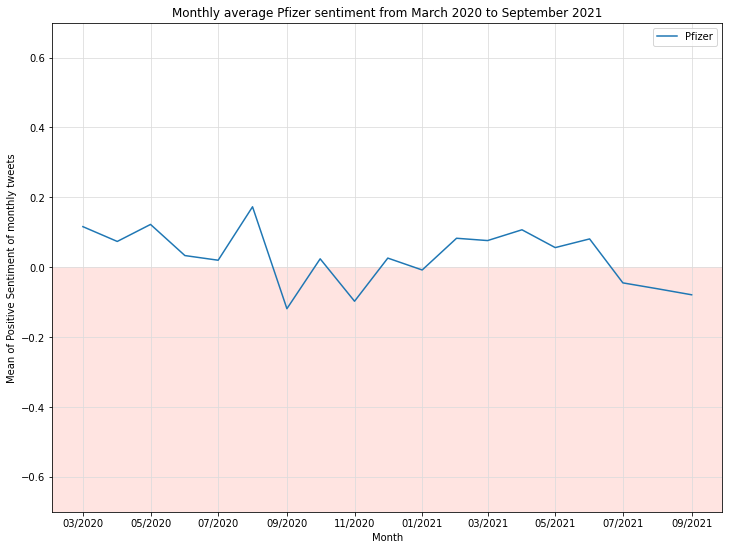

In [31]:
# graphing mean of sentiment for each month of pfizer
pfizer_month = pfizer_per_day.copy()

def startMonth(date):
  month = date.month
  year = date.year
  comp_date = str(year) + "-" + str(month) + "-1"
  return datetime.strptime(comp_date, "%Y-%m-%d")

pfizer_month["month"] = pfizer_month["datetime"].apply(startMonth)

pfizer_avg_month = pfizer_month.groupby("month")["sent_avg"].mean().reset_index()

print(pfizer_avg_month)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Pfizer sentiment from March 2020 to September 2021")
plt.plot(pfizer_avg_month["month"],pfizer_avg_month["sent_avg"], label='Pfizer')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

        month  sent_avg
0  2020-03-01  0.093429
1  2020-04-01  0.129511
2  2020-05-01 -0.356928
3  2020-06-01  0.233459
4  2020-07-01  0.020313
5  2020-08-01  0.121742
6  2020-09-01  0.072645
7  2020-10-01 -0.164020
8  2020-11-01  0.089853
9  2020-12-01  0.107577
10 2021-01-01 -0.004122
11 2021-02-01  0.059486
12 2021-03-01  0.007855
13 2021-04-01 -0.035126
14 2021-05-01  0.125089
15 2021-06-01  0.031482
16 2021-07-01  0.098092
17 2021-08-01 -0.056468
18 2021-09-01 -0.049206


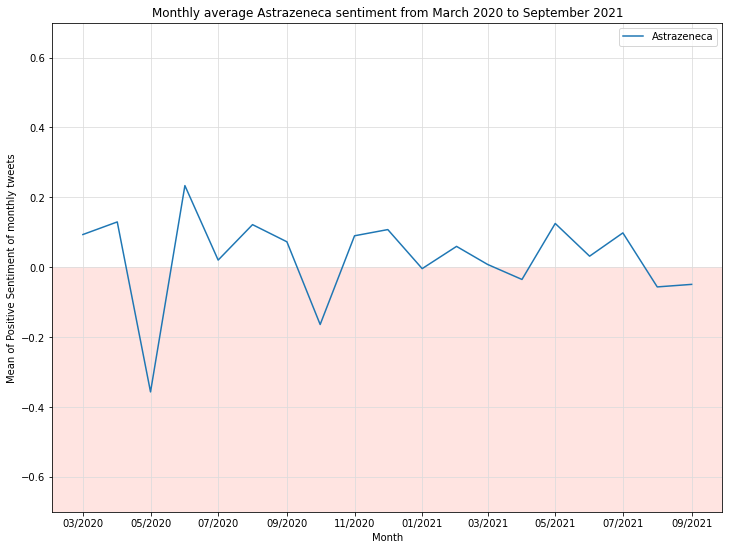

In [32]:
# graphing mean of sentiment for each month of astrazeneca
astra_month = astra_per_day.copy()

def startMonth(date):
  month = date.month
  year = date.year
  comp_date = str(year) + "-" + str(month) + "-1"
  return datetime.strptime(comp_date, "%Y-%m-%d")

astra_month["month"] = astra_month["datetime"].apply(startMonth)

astra_avg_month = astra_month.groupby("month")["sent_avg"].mean().reset_index()

print(astra_avg_month)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Astrazeneca sentiment from March 2020 to September 2021")
plt.plot(astra_avg_month["month"],astra_avg_month["sent_avg"], label='Astrazeneca')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

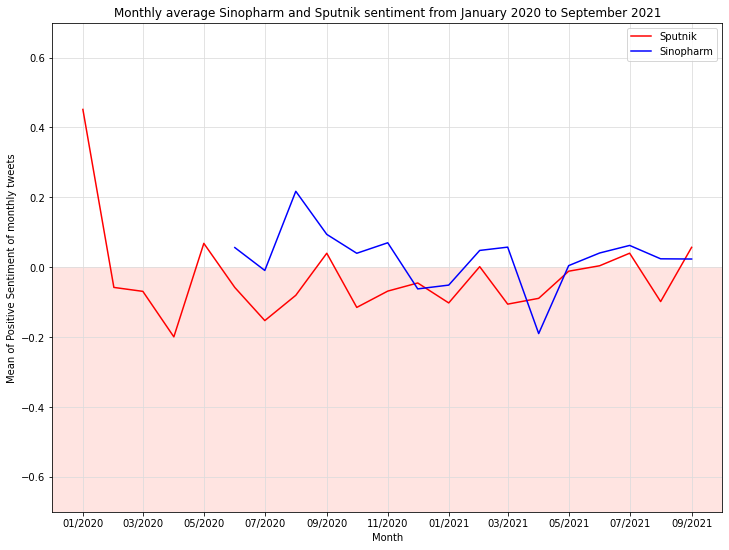

In [33]:
# graphing mean of sentiment for each month of sputnik and sinopharm

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Sinopharm and Sputnik sentiment from January 2020 to September 2021")
ax.plot(sputnik_avg_month["month"],sputnik_avg_month["sent_avg"],'red', label='Sputnik')
ax.plot(sinopharm_avg_month["month"],sinopharm_avg_month["sent_avg"],'blue', label='Sinopharm')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

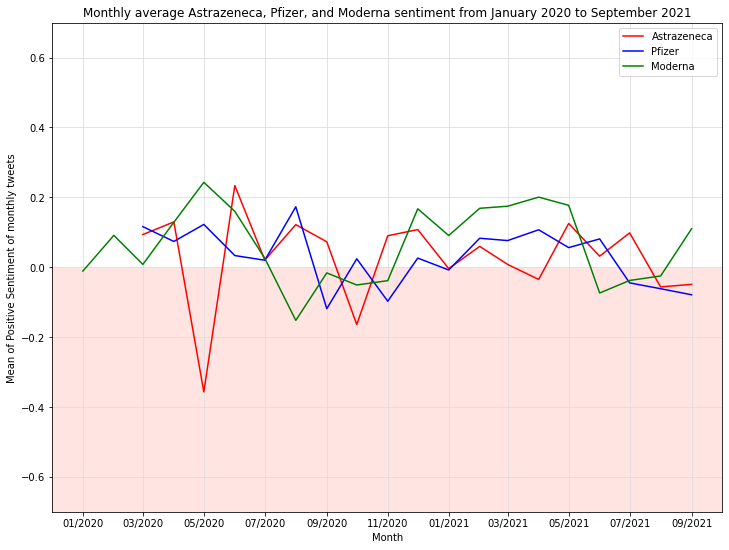

In [34]:
# graphing mean of sentiment for each month of moderna, pfizer and astrazeneca

fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Mean of Positive Sentiment of monthly tweets")
ax.set_ylim(-0.7, 0.7)
ax.grid(True, linestyle='-',color="gainsboro")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.title("Monthly average Astrazeneca, Pfizer, and Moderna sentiment from January 2020 to September 2021")
ax.plot(astra_avg_month["month"],astra_avg_month["sent_avg"],'red', label='Astrazeneca')
ax.plot(pfizer_avg_month["month"],pfizer_avg_month["sent_avg"],'blue', label='Pfizer')
ax.plot(moderna_avg_month["month"],moderna_avg_month["sent_avg"],'green', label='Moderna')
ax.axhspan(-0.7, 0, color='mistyrose')
leg = ax.legend()

plt.show()

In [35]:
# Function to get data by month for a given dataframe
def get_data_for_months(dataframe):
  months_dict = {}
  months = dataframe.month.unique()
  for month in months:
    years = month.astype('datetime64[Y]').astype(int) + 1970
    months = month.astype('datetime64[M]').astype(int) % 12 + 1
    # We only look at certain months to compare to the other paper
    if((months == 12 and years == 2020) or (months == 1 and years == 2021) or (months == 2 and years == 2021) or (months == 3 and years == 2021)):
      months_dict[month] = dataframe.loc[dataframe["month"] == month]["sent_val"]

  data_arr = []
  months_arr = []
  for month in sorted(months_dict.keys()):
    years = month.astype('datetime64[Y]').astype(int) + 1970
    months = month.astype('datetime64[M]').astype(int) % 12 + 1
    if((months == 12 and years == 2020) or (months == 1 and years == 2021) or (months == 2 and years == 2021) or (months == 3 and years == 2021)):
      data_arr.append(months_dict[month])
      months_arr.append(str(month)[0:7])

  return data_arr, months_arr

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


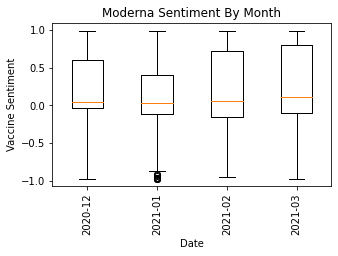

In [36]:
# Create box plot of vaccine sentiment by month for moderna
moderna_df = moderna_df.rename(columns={"sent_avg": "sent_val"})
moderna_df["month"] = moderna_df["datetime"].apply(startMonth)

data_arr, months_arr = get_data_for_months(moderna_df)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(3)
fig.set_figwidth(5)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.title("Moderna Sentiment By Month")
plt.xticks(rotation=90)

plt.boxplot(data_arr, labels=months_arr)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


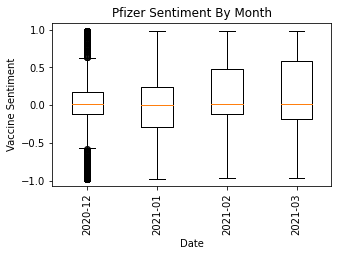

In [37]:
# Create box plot of vaccine sentiment by month for pfizer
pfizer_df = pfizer_df.rename(columns={"sent_avg": "sent_val"})
pfizer_df["month"] = pfizer_df["datetime"].apply(startMonth)
data_arr, months_arr = get_data_for_months(pfizer_df)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(3)
fig.set_figwidth(5)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.title("Pfizer Sentiment By Month")
plt.xticks(rotation=90)

plt.boxplot(data_arr, labels=months_arr)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


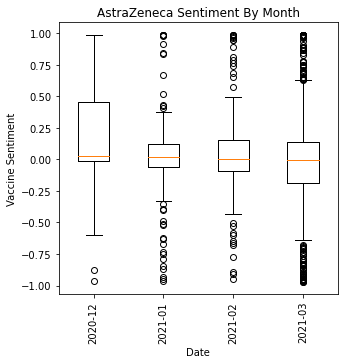

In [38]:
# Create box plot of vaccine sentiment by month for astrazeneca
astra_df = astra_df.rename(columns={"sent_avg": "sent_val"})
astra_df["month"] = astra_df["datetime"].apply(startMonth)
data_arr, months_arr = get_data_for_months(astra_df)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(5)
fig.set_figwidth(5)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.title("AstraZeneca Sentiment By Month")
plt.xticks(rotation=90)

plt.boxplot(data_arr, labels=months_arr)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


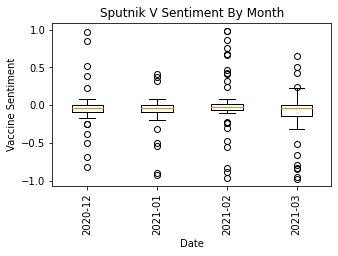

In [39]:
# Create box plot of vaccine sentiment by month for sputnik
sputnik_df = sputnik_df.rename(columns={"sent_avg": "sent_val"})
sputnik_df["month"] = sputnik_df["datetime"].apply(startMonth)
data_arr, months_arr = get_data_for_months(sputnik_df)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(3)
fig.set_figwidth(5)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.title("Sputnik V Sentiment By Month")
plt.xticks(rotation=90)

plt.boxplot(data_arr, labels=months_arr)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


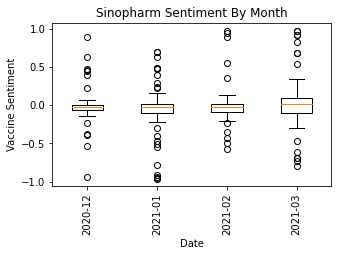

In [40]:
# Create box plot of vaccine sentiment by month for sinopharm
sinopharm_df = sinopharm_df.rename(columns={"sent_avg": "sent_val"})
sinopharm_df["month"] = sinopharm_df["datetime"].apply(startMonth)
data_arr, months_arr = get_data_for_months(sinopharm_df)

fig, ax = plt.subplots(1,1) 
fig.set_figheight(3)
fig.set_figwidth(5)
plt.xlabel("Date")
plt.ylabel("Vaccine Sentiment")
plt.title("Sinopharm Sentiment By Month")
plt.xticks(rotation=90)

plt.boxplot(data_arr, labels=months_arr)
plt.show()

In [58]:
# Create dataframe with count of tweets per month for each brand
moderna_month_count_df = moderna_df.groupby("month").count()
pfizer_month_count_df = pfizer_df.groupby("month").count()
astra_month_count_df = astra_df.groupby("month").count()
sputnik_month_count_df = sputnik_df.groupby("month").count()
sinopharm_month_count_df = sinopharm_df.groupby("month").count()

In [59]:
# Create dataframe with count of tweets per month for total dataset
all_tweets_df["month"] = all_tweets_df["datetime"].apply(startMonth)
all_month_count_df = all_tweets_df.groupby("month").count()

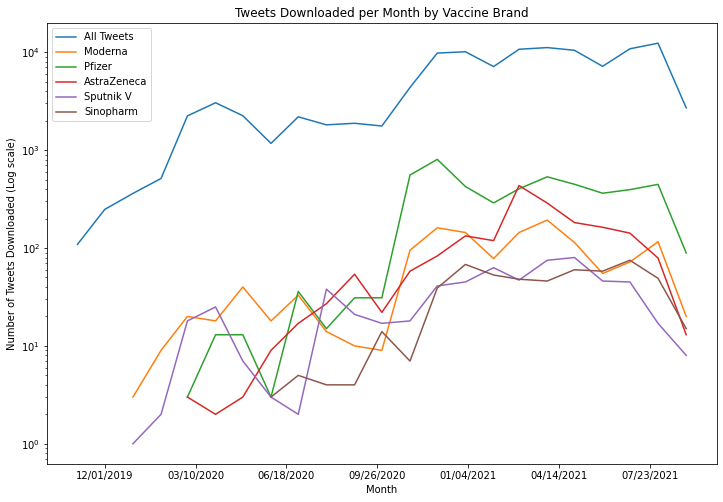

In [60]:
# Plot how many tweets we downloaded per month for each brand
fig, ax = plt.subplots(1,1) 
fig.set_figheight(9)
fig.set_figwidth(12)
plt.xlabel("Month")
plt.ylabel("Number of Tweets Downloaded (Log scale)")
plt.yscale("log")
plt.xticks(astra_per_day["datetime"])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
plt.gcf().autofmt_xdate()
plt.title("Tweets Downloaded per Month by Vaccine Brand")
#ax.set_xticklabels(afg_df["datetime"])
plt.plot(all_month_count_df.index, all_month_count_df["tweet_text"])
plt.plot(moderna_month_count_df.index, moderna_month_count_df["tweet_text"])
plt.plot(pfizer_month_count_df.index, pfizer_month_count_df["tweet_text"])
plt.plot(astra_month_count_df.index, astra_month_count_df["tweet_text"])
plt.plot(sputnik_month_count_df.index, sputnik_month_count_df["tweet_text"])
plt.plot(sinopharm_month_count_df.index, sinopharm_month_count_df["tweet_text"])
plt.legend(["All Tweets", "Moderna", "Pfizer", "AstraZeneca", "Sputnik V", "Sinopharm"])
plt.show()